## HDB Flats - Singapore
---

Goal: predict the value of the HDB flats, in this case, the resale price variable.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('datasets/prices.csv')

In [3]:
# save a copy of df for reference before preprocessing
df_raw = df.copy()

In [4]:
df.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0


In [5]:
df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

## Data Preprocessing

Split/adjust time-related features

In [6]:
# split month column to year & month
df[['year', 'month']] = df['month'].str.split('-', 1, expand=True)

In [7]:
# split remaining_lease column to year & month
df[['rl_year', 'rl_month']] = df['remaining_lease'].str.split(' years', 1, expand=True)
df['rl_month'] = df['rl_month'].str.strip("months")

In [8]:
# change datatype of split month columns
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)

In [9]:
# replace blank cells with nulls since some values are exact years without months
display(df['rl_month'][92268])
df['rl_month'] = df['rl_month'].replace(r'\s+( +\.)|#',np.nan,regex=True).replace('',0)

''

In [10]:
# change datatype of split remaining_lease columns
df['rl_year'] = df['rl_year'].astype(int)
df['rl_month'] = df['rl_month'].astype(int)

In [11]:
# change remaining lease months to total including year, we will drop the feature that performs worse later to avoid multicollinearity
df['rl_month'] = ((df['rl_year']) * 12) + df['rl_month']

Remove transformed feature to avoid multicollinearity, retain the higher correlation feature.

In [12]:
df['rl_month'].corr(df['resale_price'])

0.33184998824635425

In [13]:
df['rl_year'].corr(df['resale_price'])

0.3317167154808382

In [14]:
# drop transformed column
df = df.drop(columns=['remaining_lease'])

# drop lease_commence_date column as its essentially the same
df = df.drop(columns=['lease_commence_date'])

# drop remaining year lease to avoid multicollinearity
df = df.drop(columns=['rl_year'])

In [15]:
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,year,rl_month
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,232000.0,2017,736
1,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,250000.0,2017,727
2,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,262000.0,2017,749
3,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,265000.0,2017,745
4,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,265000.0,2017,749
...,...,...,...,...,...,...,...,...,...,...,...
92265,2,YISHUN,EXECUTIVE,406,YISHUN AVE 6,10 TO 12,148.0,Maisonette,655000.0,2021,800
92266,2,YISHUN,EXECUTIVE,355,YISHUN RING RD,10 TO 12,146.0,Maisonette,650000.0,2021,802
92267,2,YISHUN,EXECUTIVE,364,YISHUN RING RD,01 TO 03,146.0,Maisonette,607000.0,2021,794
92268,2,YISHUN,EXECUTIVE,828,YISHUN ST 81,01 TO 03,142.0,Apartment,670000.0,2021,792


## EDA
Let's first explore the distributions of the dataset's variables (including target - resale_price)


In [16]:
# Assign target variable
target = 'resale_price'

<AxesSubplot:>

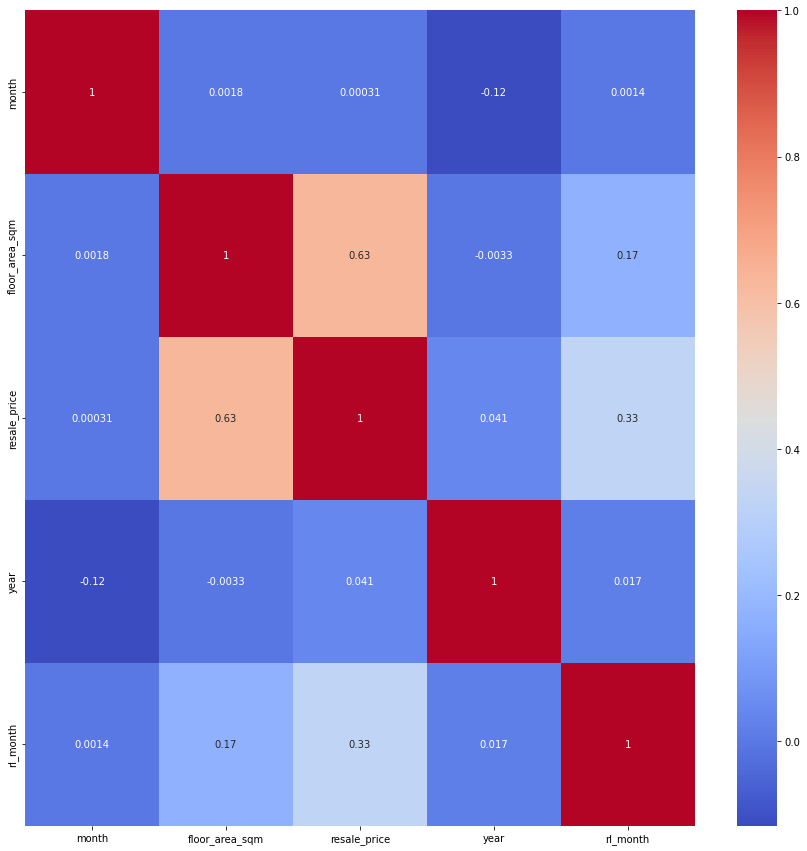

In [17]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)

No multicollinearity concerns between features excluding the target

**Numerical variables**

In [18]:
# create new df with numerical variables
df_eda = df[['month', 'floor_area_sqm', 'rl_month', 'resale_price']]

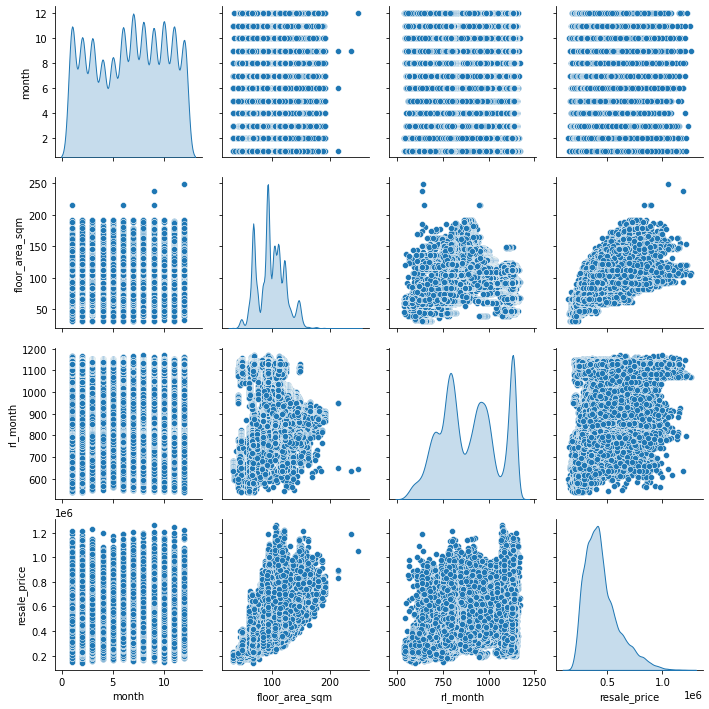

In [19]:
sns.pairplot(data=df_eda, diag_kind='kde')

**Takeaways**
1. Noticeable lower number of sales in April and May (months 4 and 5), with the other 10 months being relatively similar
2. Floor area of sold units have 3 'peaks' which could portray various typical floor plans catered at different audiences
3. Remaining lease unevenly distributed, peaking at tail end
    - possible influx of sales for more newly constructed units
4. Resale prices left skewed
    - noticeable positive correlation between floor area and resale as mentiooned earlier

Text(0.5, 1.0, 'Boxplot of: floor_area_sqm')

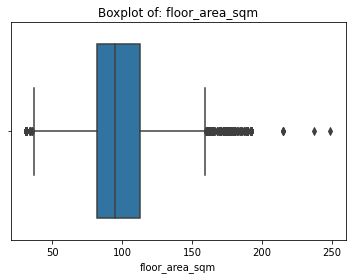

In [20]:
var = 'floor_area_sqm'
sns.boxplot(x=df[var])
plt.title('Boxplot of: ' + var)

Existence of outliers as seen from the boxplot. 3 prominent outliers beyond the cluster after the 'Maximum'.

<AxesSubplot:title={'center':'Relationship of target: resale_price vs numerical variable: floor_area_sqm'}, xlabel='floor_area_sqm', ylabel='resale_price'>

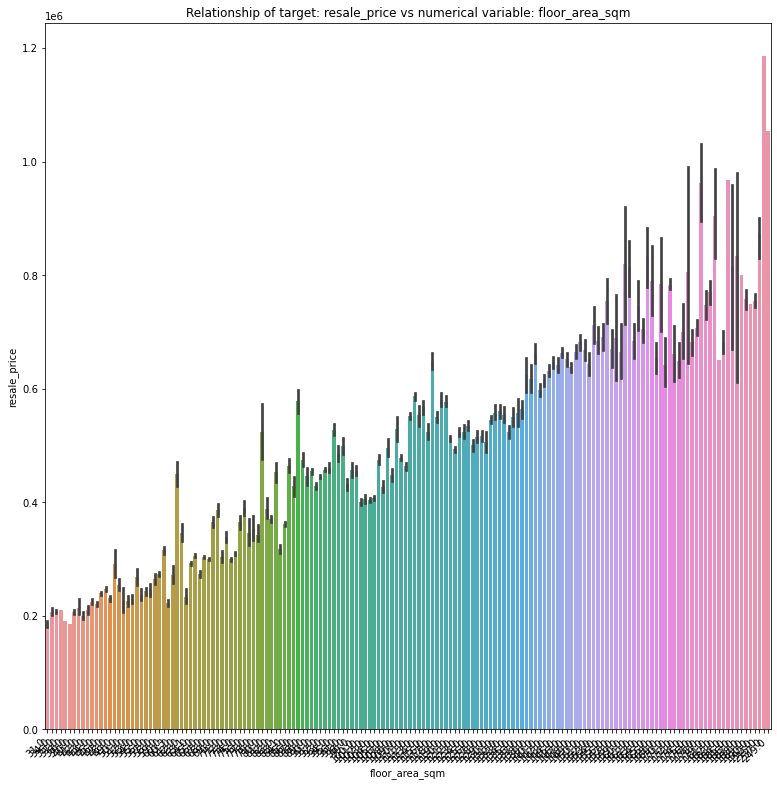

In [21]:
plt.figure(figsize=(13,13))
plt.title('Relationship of target: ' +target+ ' vs numerical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df, x=var, y=target)

Resale price is positively correlated to the floor area of the unit. 

Text(0.5, 1.0, 'Boxplot of: rl_month')

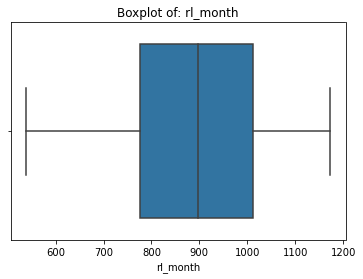

In [22]:
var = 'rl_month'
sns.boxplot(x=df[var])
plt.title('Boxplot of: ' + var)

25th to 75th percentile of remaining lease in months about 780 to 1020 months, which translates to about 65 to 85 years.

<AxesSubplot:title={'center':'Relationship of target: resale_price vs numerical variable: rl_month'}, xlabel='rl_month', ylabel='resale_price'>

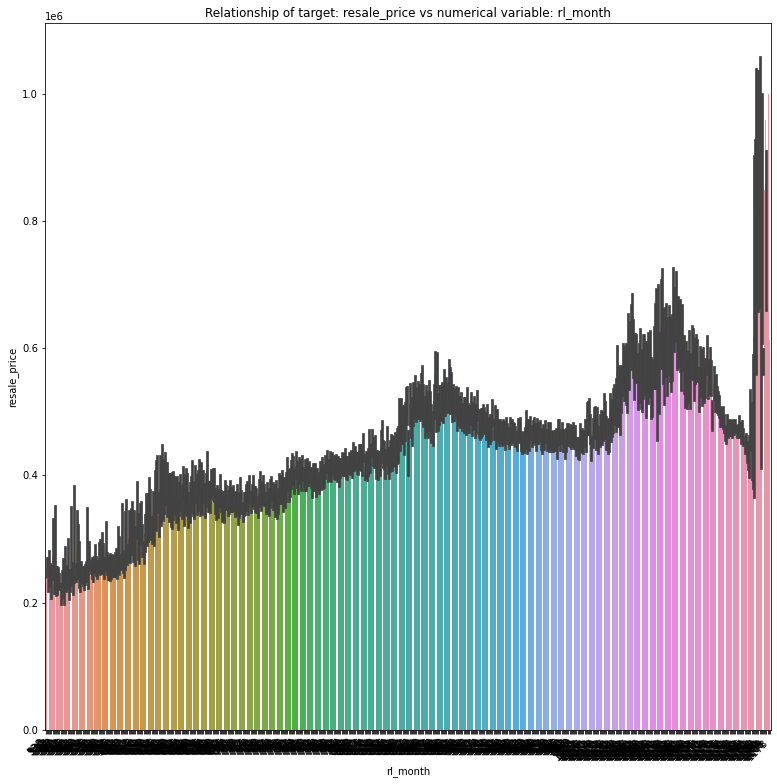

In [23]:
plt.figure(figsize=(13,13))
plt.title('Relationship of target: ' +target+ ' vs numerical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df, x=var, y=target)

Resale price is mostly positively correlated to the remaining lease of the unit. Interestingly, there is a sharp spike closer to the high end of rl_month. This could be a result of other factors that newly constructed units have as the sharp increase is inconsistent with other transactions.

Text(0.5, 1.0, 'Boxplot of: resale_price')

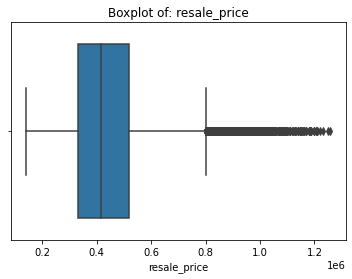

In [24]:
var = 'resale_price'
sns.boxplot(x=df[var])
plt.title('Boxplot of: ' + var)

Existence of outliers on the right end as seen from the boxplot, which is unsurprising with its right skewed nature. \
Unlike previous features, substantially more data points fall above the 'maximum', which is the 75th percentile + 1.5 IQR.

**Categorical variables**

**Variable: Year**

<AxesSubplot:title={'center':'Distribution of categorical variable: year'}, xlabel='year', ylabel='count'>

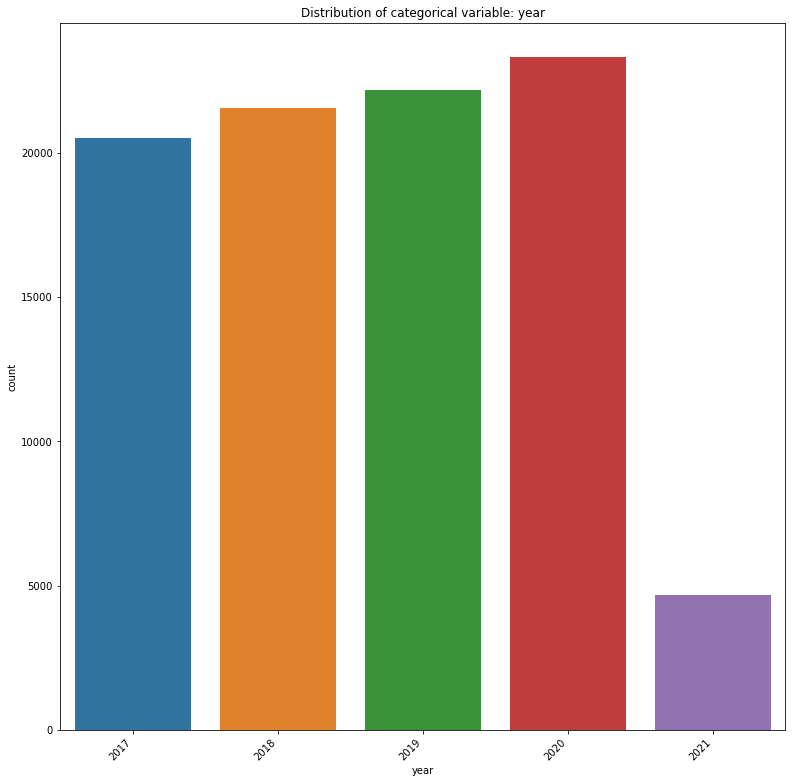

In [25]:
var = 'year'
plt.figure(figsize=(13,13))
plt.title('Distribution of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.countplot(x=df[var])

Note: Dataset cuts off at some point in 2021, not that there was a significantly decrease in sales in 2021. Years where dataset is full reflected a consistent increase in the number of flat sales from 2017 to 2020.

**Variable: Month**

In [26]:
df.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,year,rl_month
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,232000.0,2017,736


In [27]:
df.tail(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,year,rl_month
92269,2,YISHUN,EXECUTIVE,877,YISHUN ST 81,07 TO 09,145.0,Maisonette,660000.0,2021,790


Dataset started at 1/2017 and ended at 2/2021 meaning there's an additional year of records for months 1 and 2. For the sake of this portion of the eda, we isolate and remove the transcations from 2021.

In [28]:
df_eda = df.loc[(df['year'] != 2021)]

In [29]:
df_eda

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,year,rl_month
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,232000.0,2017,736
1,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,250000.0,2017,727
2,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,262000.0,2017,749
3,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,265000.0,2017,745
4,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,265000.0,2017,749
...,...,...,...,...,...,...,...,...,...,...,...
87598,12,YISHUN,EXECUTIVE,352,YISHUN RING RD,04 TO 06,146.0,Maisonette,560000.0,2020,800
87599,12,YISHUN,EXECUTIVE,356,YISHUN RING RD,01 TO 03,145.0,Apartment,540000.0,2020,801
87600,12,YISHUN,EXECUTIVE,611,YISHUN ST 61,13 TO 15,142.0,Apartment,638000.0,2020,792
87601,12,YISHUN,EXECUTIVE,834,YISHUN ST 81,10 TO 12,146.0,Maisonette,683500.0,2020,794


<AxesSubplot:title={'center':'Distribution of categorical variable: month'}, xlabel='month', ylabel='count'>

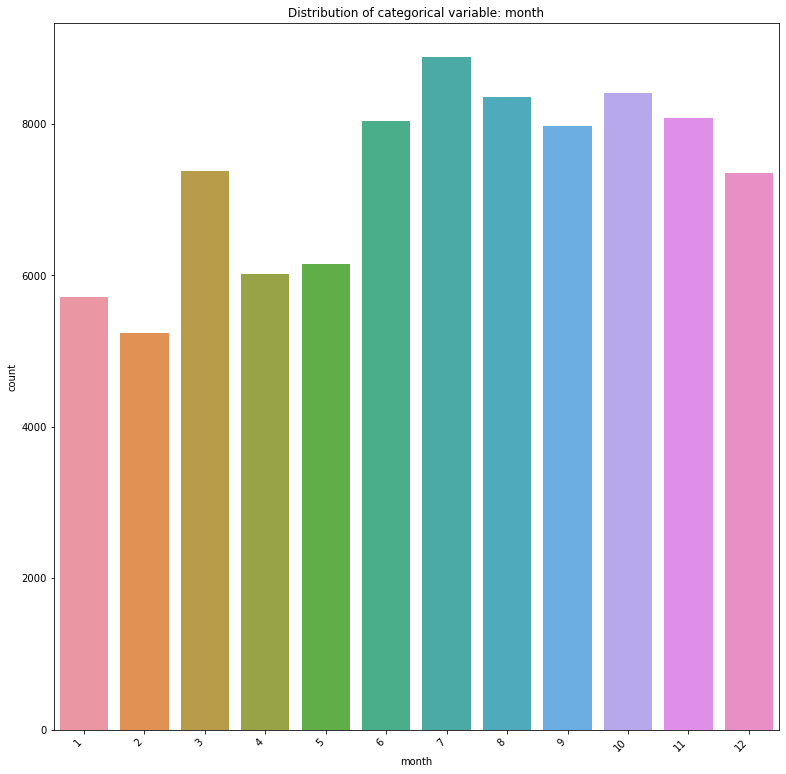

In [30]:
var = 'month'
plt.figure(figsize=(13,13))
plt.title('Distribution of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.countplot(x=df_eda[var])

**Takeaway**: 
1. Lower sales activity in 4 months from the first half of the year, months 1, 2, 4 and 5, with the other 8 months being relatively similar.

**Variable: town**

Number of transactions in each town

<AxesSubplot:title={'center':'Distribution of categorical variable: town'}, xlabel='town', ylabel='count'>

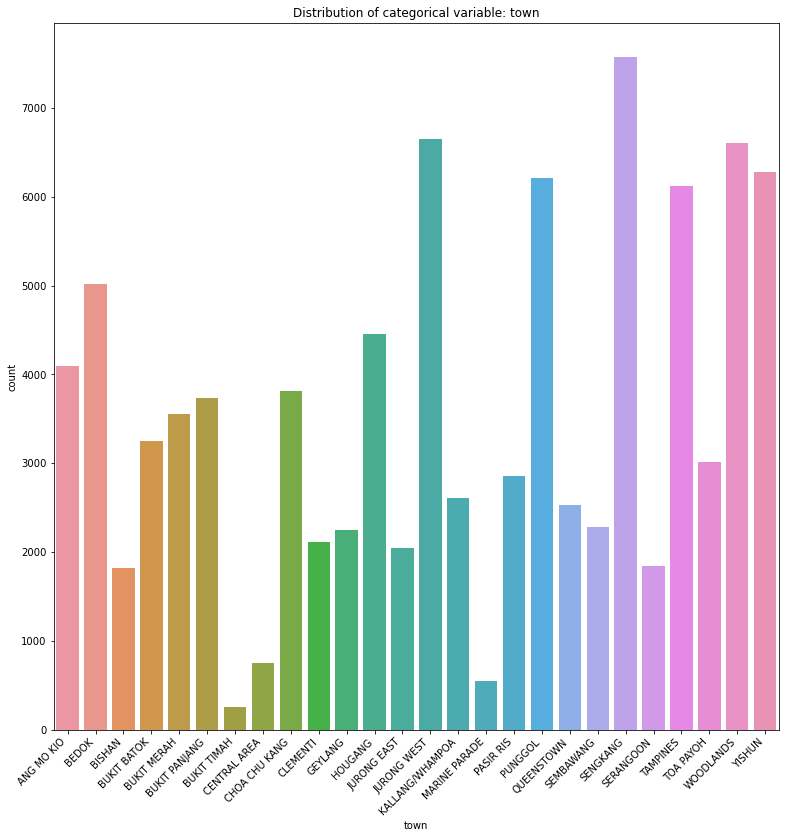

In [31]:
var = 'town'
plt.figure(figsize=(13,13))
plt.title('Distribution of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.countplot(x=df[var])

Average resale price in each town

<AxesSubplot:title={'center':'Average resale_price of categorical variable: town'}, xlabel='town', ylabel='resale_price'>

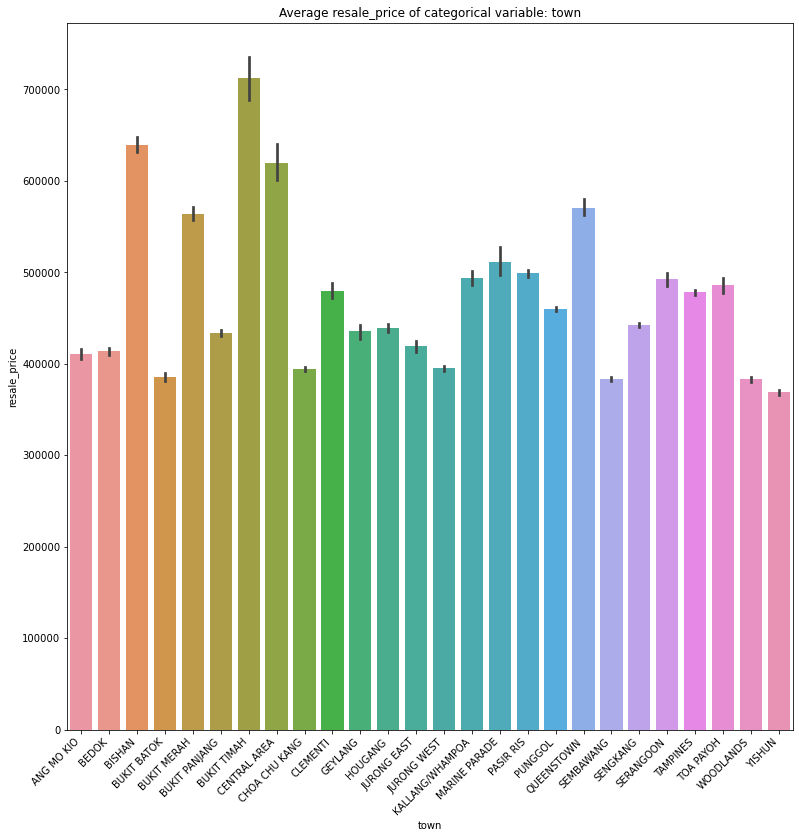

In [32]:
plt.figure(figsize=(13,13))
plt.title('Average ' + str(target) + ' of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df, x=var, y=target)

**Takeaway**
1. Uneven distribution of sales across different locations ('town') across Singapore
2. Distribution is as expected due to geographical nature
    - Three Lowest recorded areas: Bukit Timah, Central Area, and Marine Parade
        - Average resale prices in 2 of the 3 areas are top 3 in resale prices
            - This high barrier of entry could be a reason for low transactions
        - In reality, there may be fewer flats in these areas, more private housing
            - Valuations for flats in such locations may suffer as a result of low sample

<AxesSubplot:title={'center':'Distribution of categorical variable: flat_type'}, xlabel='flat_type', ylabel='count'>

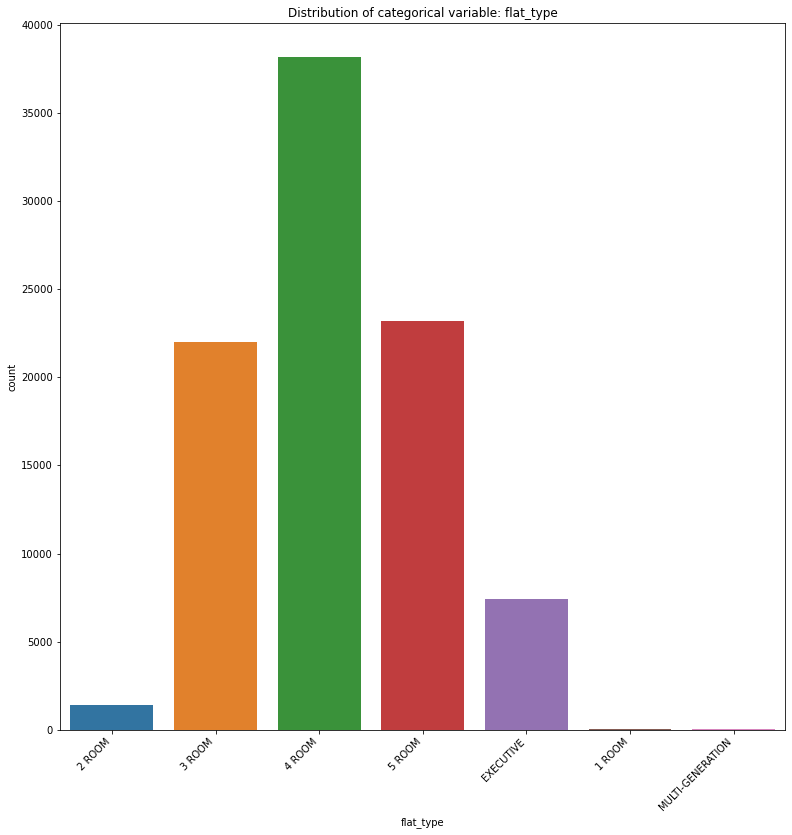

In [33]:
var = 'flat_type'
plt.figure(figsize=(13,13))
plt.title('Distribution of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.countplot(x=df[var])

<AxesSubplot:title={'center':'Average resale_price of categorical variable: flat_type'}, xlabel='flat_type', ylabel='resale_price'>

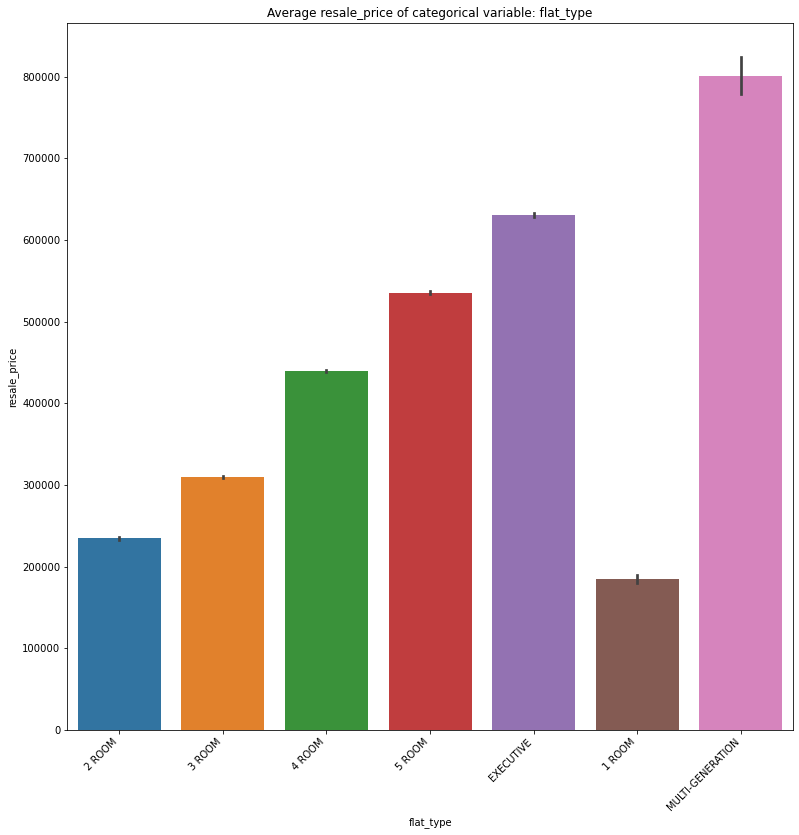

In [34]:
plt.figure(figsize=(13,13))
plt.title('Average ' + str(target) + ' of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df, x=var, y=target)

In [35]:
df['flat_type'].value_counts()

4 ROOM              38182
5 ROOM              23176
3 ROOM              21980
EXECUTIVE            7438
2 ROOM               1408
MULTI-GENERATION       44
1 ROOM                 42
Name: flat_type, dtype: int64

**Takeaway**
1. Large number of flats sales are 3 room, 4 room, and 5 room flats
    - Comprises about ~80,000 / 92,270 of sales
2. Sales of flat types 1 room, 2 room, and multi-generation are extremely low
    - Only 1408 2-room sales
    - Only 40+ 1-room and multi-generation sales
    - All 3 categories comprise of less than 2% of total sales
3. Average resale prices of room types are expected

In [36]:
df.sort_values('storey_range', inplace = True)

<AxesSubplot:title={'center':'Distribution of categorical variable: storey_range'}, xlabel='storey_range', ylabel='count'>

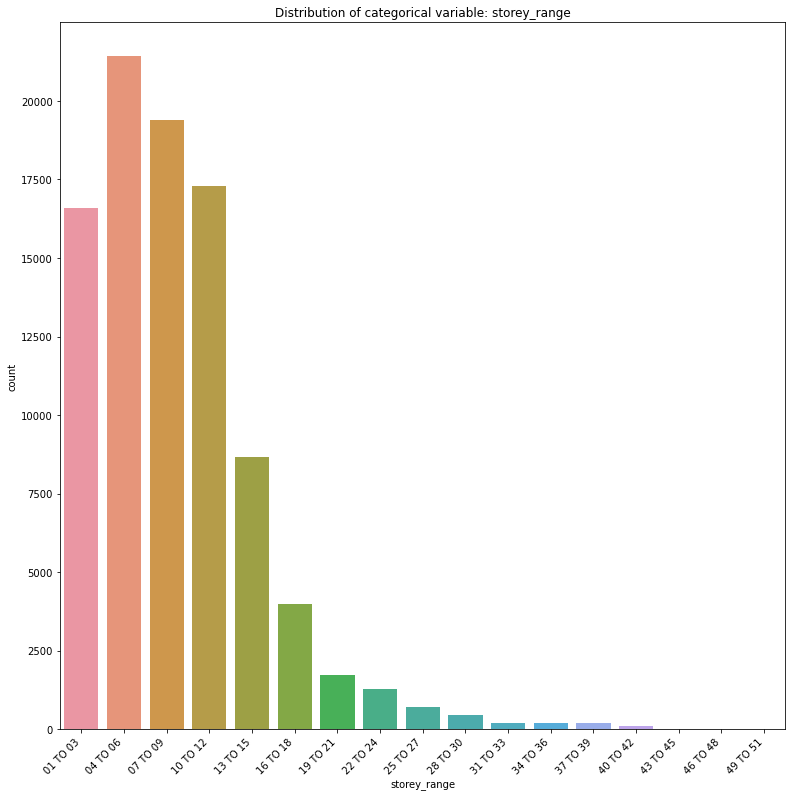

In [37]:
var = 'storey_range'
plt.figure(figsize=(13,13))
plt.title('Distribution of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.countplot(x=df[var])

<AxesSubplot:title={'center':'Average resale_price of categorical variable: storey_range'}, xlabel='storey_range', ylabel='resale_price'>

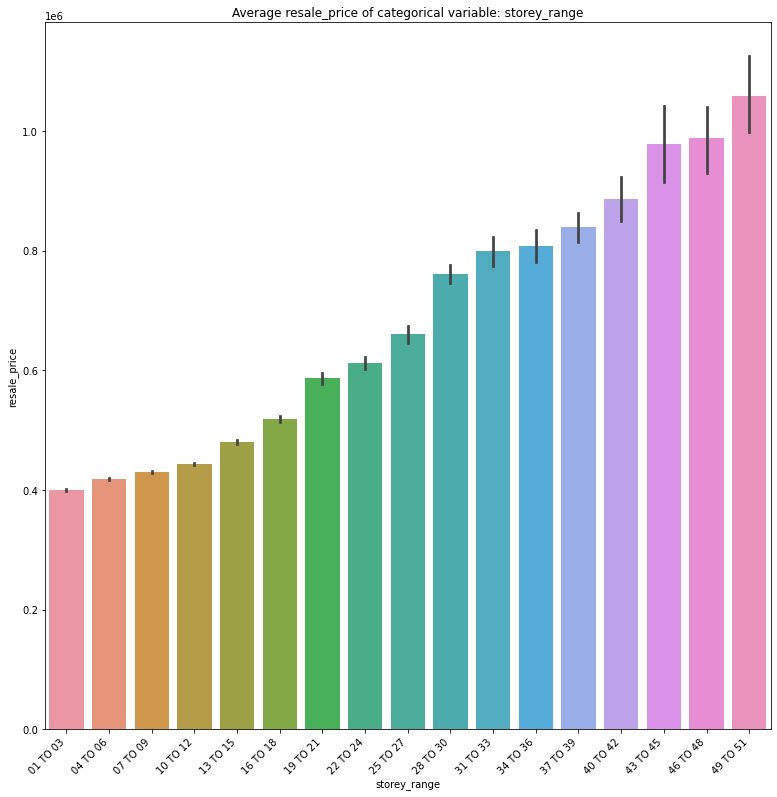

In [38]:
plt.figure(figsize=(13,13))
plt.title('Average ' + str(target) + ' of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df, x=var, y=target)

**Takeaway**
1. Number of sales of flats by storey range peaks at the second range 4 to 6 before consistently decreasing thereafter
    - Consistent decrease is unsurprising as buildings have varying heights
        - Assuming every unique building's floor has the same amount of units, it would inevitably mean there are more 5th floor units vs 15th floor units
        - Naturally it would likely result in more transactions of 5th floor vs 15th floor units
    - A lower count in 1 to 3 storey range could be explained by various reasons
        - Buyers: based on experience, buyers avoid low storey units for a variety of reasons
        - Sellers: or likely dwellers of such units may be unwilling to move
        - Infrastructure: certain buildings may be designed in ways that lower floor(s) are not fitted with residential units
        - Current information is too limited to formulate anything conclusive and further research must be undertaken       
2. Average resale prices consistently increase with units' storey ranges


<AxesSubplot:title={'center':'Distribution of categorical variable: flat_model'}, xlabel='flat_model', ylabel='count'>

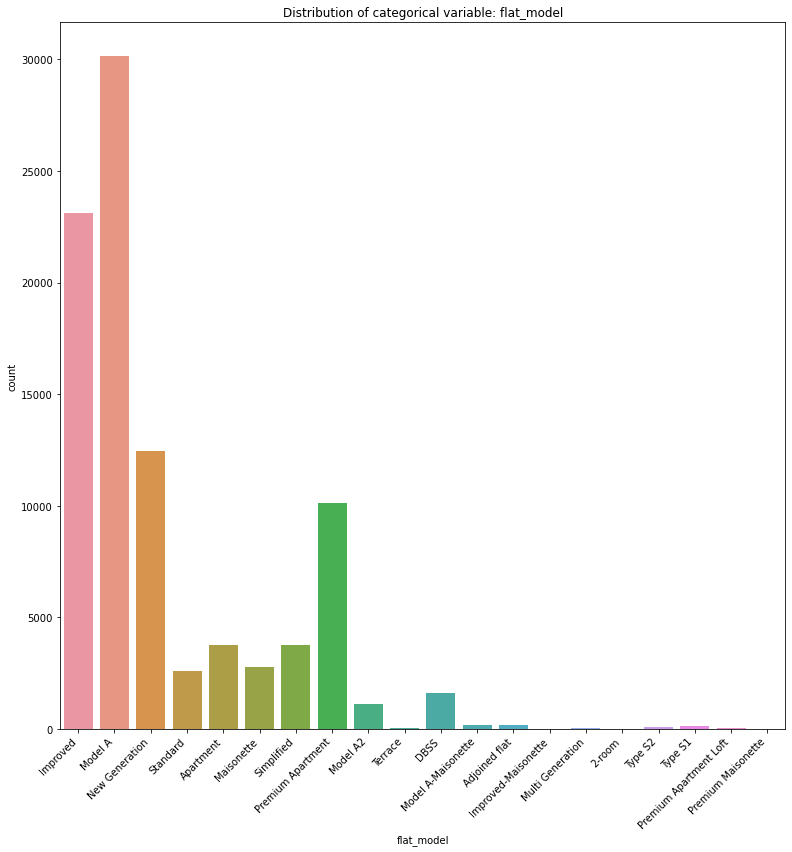

In [39]:
var = 'flat_model'
plt.figure(figsize=(13,13))
plt.title('Distribution of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.countplot(x=df[var])

<AxesSubplot:title={'center':'Average resale_price of categorical variable: flat_model'}, xlabel='flat_model', ylabel='resale_price'>

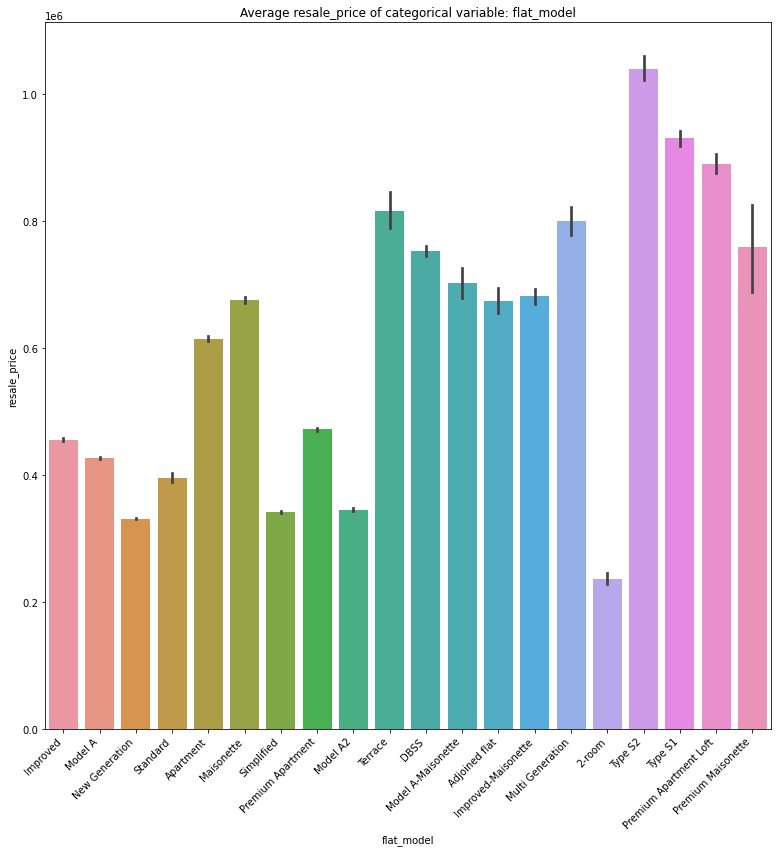

In [40]:
plt.figure(figsize=(13,13))
plt.title('Average ' + str(target) + ' of categorical variable: ' + var)
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df, x=var, y=target)

**Takeaway**
1. Flat models may not be the most consistent feature due to the existence of many negligible categories
2. Transactions mostly comprise of flat models:
    - Model A
    - Improved
    - New Generation
    - Premium Apartment
3. Highest resale prices in units categorised as Type S1, Type S2, Premium Apartment Loft
    - However, very few recorded datapoints in such categories thus might be misleading

## Feature Engineering/Transformation

In [41]:
df_raw = df.copy()
df_raw

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,year,rl_month
67125,2,PUNGGOL,5 ROOM,258A,PUNGGOL FIELD,01 TO 03,113.0,Improved,537500.0,2020,1144
81370,10,JURONG WEST,4 ROOM,929,JURONG WEST ST 92,01 TO 03,103.0,Model A,300000.0,2020,808
81371,10,JURONG WEST,4 ROOM,980,JURONG WEST ST 93,01 TO 03,105.0,Model A,355000.0,2020,813
22800,3,ANG MO KIO,3 ROOM,713,ANG MO KIO AVE 6,01 TO 03,68.0,New Generation,300000.0,2018,737
22799,3,ANG MO KIO,3 ROOM,643,ANG MO KIO AVE 5,01 TO 03,75.0,New Generation,300000.0,2018,741
...,...,...,...,...,...,...,...,...,...,...,...
8412,6,CENTRAL AREA,4 ROOM,1B,CANTONMENT RD,49 TO 51,94.0,Type S1,978000.0,2017,1111
28715,6,CENTRAL AREA,4 ROOM,1A,CANTONMENT RD,49 TO 51,94.0,Type S1,999000.0,2018,1100
52945,7,CENTRAL AREA,4 ROOM,1F,CANTONMENT RD,49 TO 51,94.0,Type S1,1110000.0,2019,1086
21842,2,CENTRAL AREA,4 ROOM,1E,CANTONMENT RD,49 TO 51,94.0,Type S1,988888.0,2018,1103


Due to the depth of dataset and nature of real estate transactions, it is fair to remove outliers from both numerical and target variable.
- Concept of dream home can lead to overpaying
- Possible private transactions
- Different qualities of interior/renovation

In [42]:
# list of numerical features
num_features = ['floor_area_sqm', 'rl_month']

# Remove outliers using 1.5 rule, revise if necessary
for i in num_features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df = df[df[i] <= (Q3+(1.5*IQR))]
    df = df[df[i] >= (Q1-(1.5*IQR))]
    df = df.reset_index(drop=True)
    
print('\n\033[1mTakeaway:\033[0m\nBefore removing outliers, the dataset had {} samples.'.format(df_raw.shape[0]))
print('After removing outliers, the dataset has {} samples.'.format(df.shape[0]))


Takeaway:
Before removing outliers, the dataset had 92270 samples.
After removing outliers, the dataset has 91742 samples.


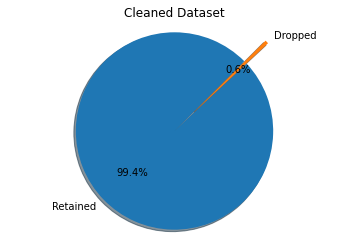

In [43]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Retained', 'Dropped'
sizes = [df.shape[0], df_raw.shape[0] - df.shape[0]]
explode = (0, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Cleaned Dataset')
plt.show()

Amount of outliers removed are not significant.

In [44]:
# Creating dummies for categorical variables
df = pd.get_dummies(df, columns=[ 'year', 'town', 'flat_type','street_name','storey_range', 'flat_model'], drop_first=True)

## Train/Test Split

Test 8 different relevant models and evaluate their performance.

In [45]:
# Train/Test Split
features = [col for col in df._get_numeric_data().columns if col != 'resale_price']
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Models Summary of Below

|Regression Model|Test Results|MAE|RMSE
|:--|:-:|:-:|:-:|
|Linear|0.93178|30229.73|40407.48|
|Ridge|0.93178|30230.94|40408.94|
|Lasso|0.43845|84096.15|115935.17|
|Elastic Net|0.49837|79096.89|109574.81|
|Decision Tree|0.93546|27492.95|39304.76|
|Ada Boost|0.24715|118581.64|134237.44|
|Gradient Boost|0.84293|45124.16|61313.33|
|**Random Forest**|**0.96286**|21117.92|29185.03|

Recall: Target variable distribution is somehow normally distributed so no transformations are applied on it.
- Ada Boost performed extremely poorly possibly due to the high amount of anomalies in the target variable as mentioned during the EDA phase.

In [46]:
# Create a LinearRegression object
lr= LinearRegression()
# Fit X and y 
lr.fit(X_train, y_train)
ypred = lr.predict(X_test)
# Metrics to evaluate your model 
r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred))

(0.931784179568858, 30229.729995388283, 40407.4832274637)

In [47]:
### Ridge regression
# Test out 100 different evenly spaced alpha values between 0.1 and 10 on default 5-folds of data set and adopt the best performing alpha
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

ridge.fit(X_train, y_train)
yrid = ridge.predict(X_test)

r2_score(y_test, yrid), mean_absolute_error(y_test, yrid), np.sqrt(mean_squared_error(y_test, yrid))

(0.9317792731418384, 30230.94471629432, 40408.93635667533)

In [48]:
### Lasso regression
# Testing out 200 different alpha values on default 5-folds of data set and adopt the best performing alpha
lasso = LassoCV(n_alphas=200)

# Lasso R2 on train & test
lasso.fit(X_train, y_train)
ylas = lasso.predict(X_test)

r2_score(y_test, ylas), mean_absolute_error(y_test, ylas), np.sqrt(mean_squared_error(y_test, ylas))

(0.4384454536198572, 84096.15466831755, 115935.1749694693)

In [49]:
# Elastic Net Regression model
elas = ElasticNet().fit(X_train,y_train)
yelas = elas.predict(X_test)

r2_score(y_test, yelas), mean_absolute_error(y_test, yelas), np.sqrt(mean_squared_error(y_test, yelas))

(0.4983706048169989, 79096.88598700154, 109574.81269174775)

In [50]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat = dt.predict(X_test)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

(0.9352186654183089, 27560.719338158353, 39377.1421438898)

In [51]:
model = AdaBoostRegressor()
# # transforming target variable through quantile transformer
# ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
model.fit(X_train, y_train)
yhat = model.predict(X_test)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

(0.2471493650596711, 118581.64337851867, 134237.43913249666)

In [52]:
model = GradientBoostingRegressor()
# # transforming target variable through quantile transformer
# ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
model.fit(X_train, y_train)
yhat = model.predict(X_test)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

(0.8429379246241373, 45124.158728041606, 61313.33141746982)

In [53]:
model = RandomForestRegressor()
# # transforming target variable through quantile transformer
# ttr = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
model.fit(X_train, y_train)
yhat = model.predict(X_test)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

(0.9628608415989546, 21117.920473516617, 29815.031808087446)

### Conclusion

Final model, Random Forest, has a R score of 96.29% and is sufficiently accurate.
- Parameter tuning can be done if accuracy is deemed to be lacking.